# Benchmarking bilinear regridding

In this notebook we compare the results of three bilinear regridding methods:
- The CDO (Climate Data Operators) command line program.
- The xESMF xarray extension (based on the Earth System Modelling Framework).
- xarray's `interp` method, wrapped as an accessor by `xarray-regrid`.

The data to resample is the ERA5 monthly dataset, for the dewpoint temperature.

We start with importing the required modules, starting up Dask and loading in the data:

In [1]:
from time import time
import dask.distributed
import xarray_regrid  # Importing this will make Dataset.regrid accessible.
import xarray as xr
from xarray_regrid import Grid, create_regridding_dataset
import xesmf as xe

client = dask.distributed.Client()

ds = xr.open_dataset(
    "data/era5_2m_dewpoint_temperature_2000_monthly.nc",
)

Both `xarray-regrid` and `xESMF` require a dataset to resample to.

We use the `Grid` dataclass and `create_regridding_dataset` function from `xarray-regrid` to create the dataset:

In [2]:
new_grid = Grid(
    north=90,
    east=180,
    south=45,
    west=90,
    resolution_lat=0.17,
    resolution_lon=0.17,
)
target_dataset = create_regridding_dataset(new_grid)
target_dataset

<xarray.Dataset>
Dimensions:    (latitude: 265, longitude: 530)
Coordinates:
  * latitude   (latitude) float64 45.0 45.17 45.34 45.51 ... 89.54 89.71 89.88
  * longitude  (longitude) float64 90.0 90.17 90.34 90.51 ... 179.6 179.8 179.9
Data variables:
    *empty*

## xarray-regrid

With `xarray-regrid` you can access the regridding utilities by using `Dataset.regrid`.

To make the comparison fair the lazy dataset is computed, to actually have the regridding performed.

In [3]:
t0 = time()

data_regrid = ds.regrid.to_dataset(target_dataset, method="linear")
data_regrid = data_regrid.compute()

print(f"Elapsed time: {time() - t0:.3f} seconds")

Elapsed time: 0.120 seconds


## CDO

The CDO data was regridded using the terminal.

To ensure that the regridding is most accurate, the dataset was first converted to 64-bit floats:
 - `cdo -b 64 -copy era5_2m_dewpoint_temperature_2000_monthly.nc era5_2m_dewpoint_temperature_2000_monthly_64b.nc`
 - `cdo -b 64 -copy new_grid.nc new_grid_64b.nc`

Next, the data can be regridded:
 - `cdo remapbil,new_grid_64b.nc era5_2m_dewpoint_temperature_2000_monthly_64b.nc cdo_bilinear_64b.nc`


In [4]:
data_cdo = xr.open_dataset("data/cdo_bilinear_64b.nc")

## xESMF

For xESMF the regridding weights are first computed (`xe.Regridder`). 

After that, the regridder can be used to regrid the dataset:

In [5]:
t0 = time()

regridder = xe.Regridder(ds, target_dataset, "bilinear")
data_esmf: xr.Dataset = regridder(ds, keep_attrs=True)

print(f"Elapsed time: {time() - t0:.3f} seconds")

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Elapsed time: 11.839 seconds


## Comparison

Now the data has been regridded using all three available methods, we can compare the results.

The following code block computes the relative error `(a-b)/a` between the three datasets. As you see, the method `xarray-regrid` uses has (near) identical results compared to the CDO regridding (only floating point errors of ~1e-8). xESMF seems to (subtly) deviate from the CDO and xarray-regrid results.

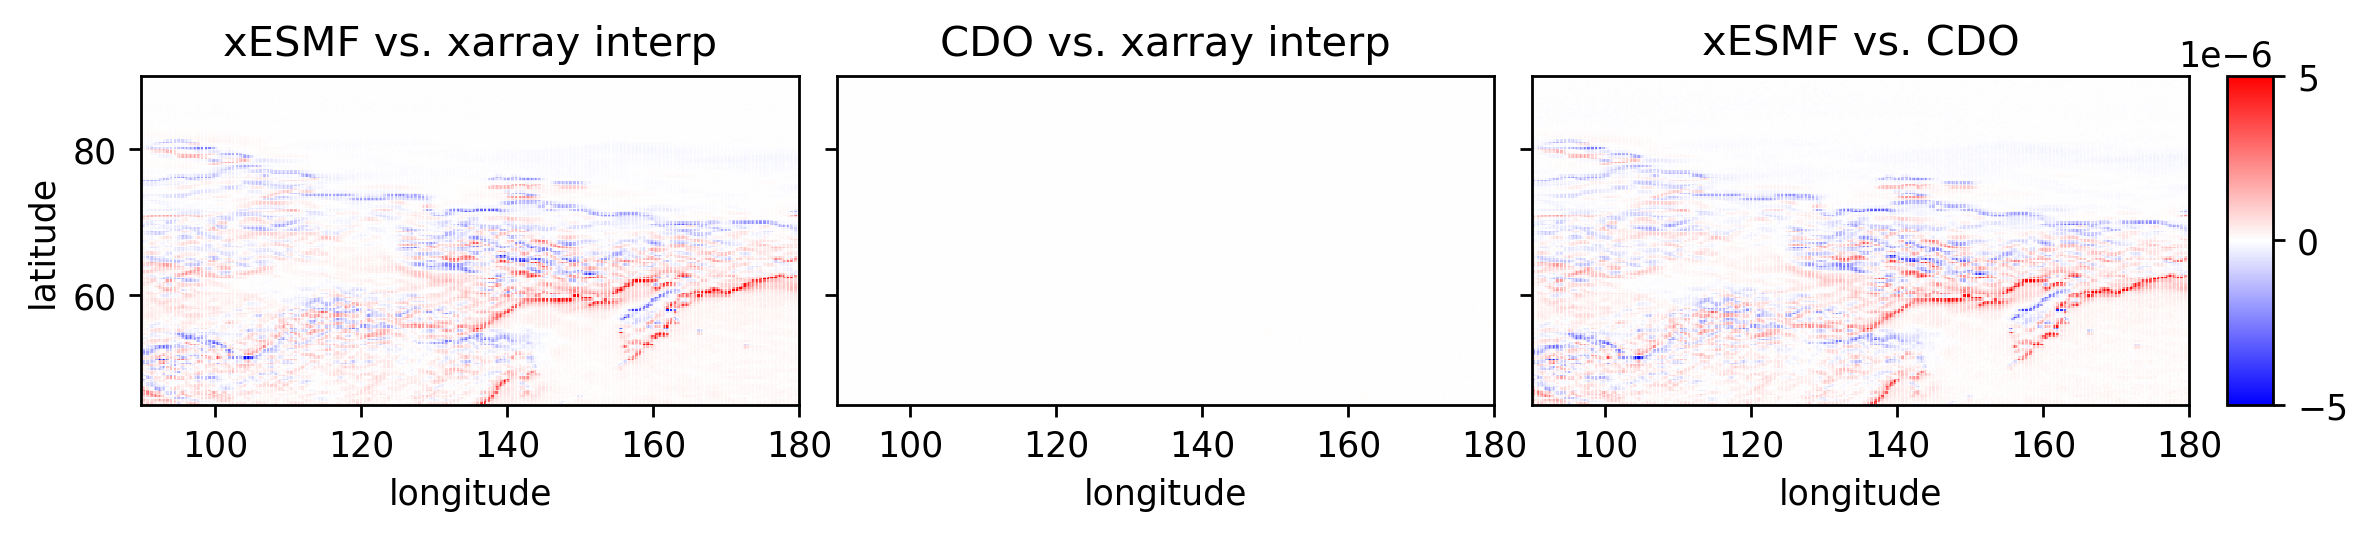

In [6]:
from benchmark_utils import plot_comparison

plot_comparison(data_regrid, data_esmf, data_cdo, vmin=-0.5e-5, vmax=0.5e-5)